# Sentiment Analysis
## GRU/LSTM Skip Connections & Hyperparameter Tuning

Though I already saw very good results with the GRU and LSTM networks of the previous notebook, in this notebook I'll be enhancing the neural networks by incorporating skip connections as well. Then I will tune the network to find the optimal parameters.

### Libraries & Dataset

To pack the sequences easily I'll be using the legacy version of torchtext which provides some functionality that has been removed from later versions. So you first need to install the specific version below. (It might conflict with some packages, but I won't be using these.)


In [1]:
!pip install -U torchtext==0.9.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 13.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 735.5/735.5 MB 941.9 kB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0
    Uninstalling torch-1.11.0:
      Successfully uninstalled torch-1.11.0
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.12.0
    Uninstalling torchtext-0.12.0:
      Successfully uninstalled torchtext-0.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchmetrics 0.11.0 requires torch>=1.8.1, but you have torch 1.8.0 which is incompatible.
pytorch-lightning 1.8.6 requires torch>=1.9.0, but you have torch 1.8.0 which is incompatible.
allennlp 2.10.1 requires torch<1.13.0,>=1.10.0, but you have torch 1.8.0 which is incompatible.


#### Libraries

In [2]:
# Math, String, etc
import sys
import re
import os
import string
import time
import datetime
import random
import math

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
import torchtext

# Numpy, Plotting, Metrics
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn

# Testing and metrics
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, classification_report
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

#### Functions for training & evaluation

In [3]:
# Function to train for one epoch
def trainEpoch(optimizer, dataloader, lossfunc, neuralnetwork, device, display=True, clip_value = 0.6):

    losses = []

    # For each batch
    for batch, data in enumerate(dataloader):

        x, x_lengths = data.review
        y = data.rating
        
        # Predict and calculate loss
        prediction = neuralnetwork(x, x_lengths)
        loss = lossfunc(prediction, y)
        losses.append(loss.item())

        # Inform the weights
        optimizer.zero_grad()
        loss.backward()
        
        # Clip the gradients
        nn.utils.clip_grad_norm_(neuralnetwork.parameters(), clip_value)
        optimizer.step()
        
        # When display is set print every 64 the loss
        if(display):
            if batch % 64 == 0:
                size = len(dataloader.dataset)
                loss, current = loss.item(), batch * len(x_lengths)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


    meanloss = 0
    if len(losses)!=0:
        # The total mean loss
        meanloss = sum(losses)/len(losses)
    return meanloss
 
# Function to train a network
def trainNetwork(epochs, optimizer, dataloader, lossfunc, neuralnetwork, device, display=True, clip_value = 0.6):

    # For each epoch
    for epoch in range(epochs):
        if (display):
            print(f"\nEpoch {epoch+1}\n_________________________________")
        trainEpoch(optimizer, dataloader, lossfunc, neuralnetwork, device, display, clip_value)
        if (display):
            print("_________________________________")
        
    # Returns the neural network
    return neuralnetwork

# Evaluation function
def evaluationFunction(dataloader, model, lossfunc, device, display=True):

    # Variable initialisation
    correctCount = 0
    sampleCount = 0
    losses = []
    preds = []
    trues = []
    probs = []

    # So the model is in eval mode
    model.eval()
    with torch.no_grad():
        
        for batch, data in enumerate(dataloader):
            
            x, x_lengths = data.review
            y = data.rating

            # Make predictions
            scores = model(x, x_lengths)
            _, predictions = scores.max(1)

            # Probability estimates of the positive class
            y_probs = torch.sigmoid(scores[:,1]).cpu()
            
            # Loss
            loss = lossfunc(scores, y).item()
            losses.append(loss)

            # Saving them for the metrics later
            predictions= torch.abs(predictions.cpu())
            y=y.cpu()
            probs.extend(y_probs.numpy())
            preds.extend(predictions.numpy())
            trues.extend(y.numpy())
            correctCount += (predictions==y).sum()
            sampleCount += predictions.size(0)

    # Metric calculations
    f1macro = f1_score(torch.tensor(trues),torch.tensor(preds), average="macro").item() * 100
    accuracy = float(correctCount) / float(sampleCount) * 100
    meanloss = sum(losses)/len(losses)
    recall = recall_score(y_true=trues, y_pred=preds) * 100
    precision = precision_score(y_true=trues, y_pred=preds) * 100

    # Printing them if display is not false
    if display:
        print("\nEvaluation Results")
        print("_________________________________")
        print(
            f"Predicted {correctCount} / {sampleCount} correctly"
            f"\nMean Loss: {meanloss:.2f} "
            f"\nRecall: {recall:.2f}%"
            f"\nPrecision: {precision:.2f}%"
            f"\nAccuracy: {accuracy:.2f}%"
            f"\nMacro Averaged F1-score: {f1macro:.2f}%"
            )
        print("_________________________________")

    # Reset the model to train mode
    model.train()

    return trues, preds, probs ,meanloss, accuracy, f1macro, recall, precision

# Confusion Matrix plotting
def confusionMatrix(trues, preds):
    names =["negative", "positive"]
    cfmatr = confusion_matrix(trues, preds)
    df_cm = pd.DataFrame(cfmatr/np.sum(cfmatr) * 2, index = [i for i in names],
                     columns = [i for i in names])
    plt.figure(figsize = (9,9))
    seaborn.heatmap(df_cm, cmap='viridis_r', annot=True)
    plt.show()

# Roc Curve plotting and also returns roc auc score
def rocCurve(trues, preds, probs):
    false_positive_rate, true_positive_rate, threshold = roc_curve(trues, probs)
    roc_auc = roc_auc_score(trues, preds)
    plt.style.use('seaborn')
    plt.subplots(figsize=(8,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, label="AUC="+str(roc_auc))
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7") 
    plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

    return roc_auc

def seedTorch(seed=33):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

# Training till loss stops improving for patience
def earlyStop(device, model, display, epochs, traindataloader, valdataloader, lr, opti, lossfunc, patience, clip_value = 0.6):

    stopepoch=0
    countStop=0
    bestMeanloss= sys.float_info.max
    optimizer = opti(model.parameters(), lr = lr , weight_decay=1e-6)
    scheduler=lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.4, patience=1, verbose=False)

    # For each epoch
    for epoch in range(epochs):

        # If iterations are equal to patience
        if countStop==patience:
            print("Early stopping on epoch: ", epoch)
            stopepoch=epoch
            break

        if (display):
            print(f"Epoch {epoch+1}\n__________________________________")
        meanLoss = trainEpoch(optimizer, traindataloader, lossfunc,  model, device, display, clip_value = 0.6)
        _, _, _, meanlossval, accura, macrof1, recall, precision =  evaluationFunction(valdataloader, model, lossfunc, device, display)

        # If mean loss is less than the best so far
        if bestMeanloss>meanlossval:
            countStop=0
            bestMeanloss=meanlossval
        else:
            countStop+=1
        
        scheduler.step(meanLoss)    

    return model, stopepoch

# Function automating finding best model
def optimalModel(device, model, epochs, traindataloader, valdataloader, optimizer, lossfunc, display=False,clip_value = 0.6):

    # Variable initialisation
    bestf1=0
    bestepoch=0
    trainlosses = []
    validlosses = []
    average = 0
    
    # For each epoch
    for epoch in range(epochs):

        if (display):
            print(f"Epoch {epoch+1}\n__________________________________")
        
        # Train the model
        meanLoss = trainEpoch(optimizer, traindataloader, lossfunc,  model, device, display, clip_value)

        # Evaluation
        _, _, _, meanlossval, accura, macrof1, recall, precision = evaluationFunction(valdataloader, model, lossfunc, device, display)

        if (display):
            print("Training loss: ", meanLoss , " validation loss: ", meanlossval, " and accuracy: ", accura)
    
        trainlosses.append(meanLoss)
        validlosses.append(meanlossval)
        average += abs(meanLoss-meanlossval)
        
        # If f1 score is better
        if (bestf1<macrof1):
            bestepoch=epoch
            bestf1=macrof1

            # Save the model
            torch.save(model.state_dict(), './bestModel.pt')
            torch.save(optimizer.state_dict(), './bestOptimizer.pt')
    
        if(display):
            print("__________________________________")

    print("Training loss - validation loss average difference: ", abs(average/len(trainlosses)))

    x = list(range(0, len(trainlosses)))
    plt.style.use('seaborn')
    plt.plot(x, trainlosses, linestyle="-", label="Training")
    plt.plot(x, validlosses, linestyle="-", label="Validation")
    plt.legend()
    plt.show()

    return bestepoch
    
DEVICE='cuda'
torch.cuda.is_available()

True

In [4]:
df = pd.read_csv("/kaggle/input/imdbreviews/imdb-reviews.csv", sep = '\t')
df.columns = ['url', 'rating', 'review']
X = df['review']
Y = df[['rating']].copy()

# classify the ratings as positive and negative
Y.loc[Y['rating'] <= 5, 'rating'] = 0
Y.loc[Y['rating'] > 5, 'rating'] = 1

frames = [X, Y]
conc = pd.concat(frames, axis=1)
conc.to_csv('proper_data.csv', index=None)
df = pd.read_csv('/kaggle/input/properdata/proper_data.csv')
df.head()

,review,rating
0,I thought this was a quiet good movie. It was ...,1.0
1,Wagon Master is a very unique film amongst Joh...,1.0
2,This film has to be as near to perfect a film ...,1.0
3,I gave this 4 stars because it has a lot of in...,0.0
4,This movie is really genuine and random. It's ...,1.0


This time using the 80% of the data from the start.

In [5]:
# Field and Label Field for review and sentiment
REVIEW = torchtext.legacy.data.Field(tokenize='spacy',tokenizer_language='en_core_web_sm', include_lengths=True)
SENTIMENT = torchtext.legacy.data.LabelField(dtype=torch.long)
fields = [('review', REVIEW), ('rating', SENTIMENT)]
dataset = torchtext.legacy.data.TabularDataset(path='/kaggle/input/properdata/proper_data.csv', format='csv', skip_header=True, fields=fields)
train_dataset, test_dataset = dataset.split(split_ratio=[0.8, 0.2])
train_dataset, val_dataset = train_dataset.split(split_ratio=[0.85, 0.15])

Build vocabulary of 20,000 words and dataloaders.

In [6]:
DEVICE = 'cuda'
VOCAB_SIZE = 20000
BATCH_SIZE = 32
REVIEW.build_vocab(train_dataset, max_size=VOCAB_SIZE, vectors='glove.6B.100d', unk_init=torch.Tensor.normal_)
SENTIMENT.build_vocab(train_dataset)
train_dataloader, val_dataloader, test_dataloader = torchtext.legacy.data.BucketIterator.splits((train_dataset, val_dataset, test_dataset), batch_size=BATCH_SIZE, sort_within_batch=True, sort_key=lambda x: len(x.review), device=DEVICE)

.vector_cache/glove.6B.zip: 862MB [02:39, 5.40MB/s]                               
100%|█████████▉| 399999/400000 [00:15<00:00, 26348.47it/s]


#### Initial Test

In [30]:
class GRU_05(torch.nn.Module):
    def __init__(self, input, embedding, hidden, layers, output, heads, dropout=0.1):
        super().__init__()
        self.embedding = torch.nn.Embedding(input, embedding)
        self.gru = torch.nn.GRU(input_size=embedding, hidden_size=hidden, num_layers=layers, bidirectional=True)
        self.dropout = torch.nn.Dropout(p=dropout)
        self.multiheaded_attention = torch.nn.ModuleList([torch.nn.Linear(hidden*2, 1) for _ in range(heads)])
        self.linear = torch.nn.Linear(hidden*2*heads, output)

    def forward(self, X, X_length):
        
        embedded = self.embedding(X)
        sequence = torch.nn.utils.rnn.pack_padded_sequence(embedded, X_length.cpu())
        _, h_0 = self.gru(sequence)
        h_0 = torch.cat((h_0[-2,:,:], h_0[-1,:,:]), dim=1)
        h_0 = self.dropout(h_0)
        attention_outputs = []
        for attention_head in self.multiheaded_attention:
            attention = F.softmax(attention_head(h_0), dim=1)
            attention_output = h_0 * attention
            attention_outputs.append(attention_output)
        
        # Concatenate the attention along the hidden dimension
        h_0 = torch.cat(attention_outputs, dim=1)
        
        output = self.linear(h_0)
        return output

A first test with the network of the previous notebook.

Early stopping on epoch:  4
Best F1 score after  4  epochs.
Training Time: 2.66 minutes

Evaluation Results
_________________________________
Predicted 8031 / 9002 correctly
Mean Loss: 0.42 
Recall: 91.86%
Precision: 87.42%
Accuracy: 89.21%
Macro Averaged F1-score: 89.20%
_________________________________


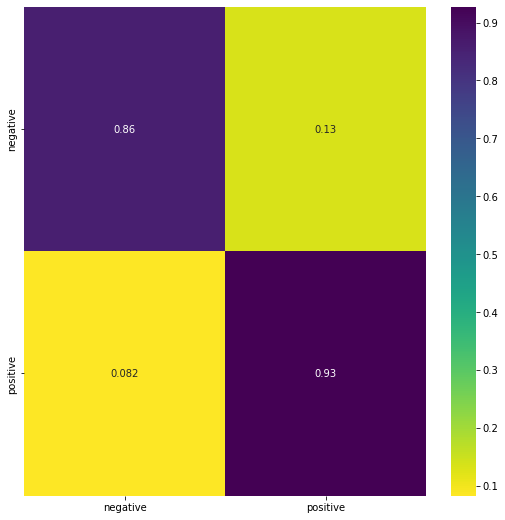

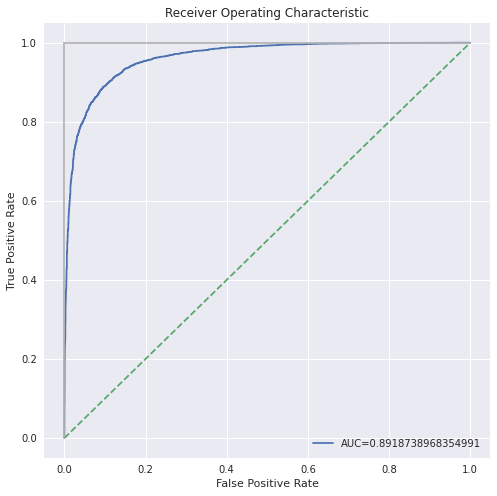

In [8]:
LR = 0.0045
EPOCHS = 6
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
HIDDEN = 48
LAYERS = 2
DROPOUT = 0.15
CLIP_VALUE = 0.7
HEADS = 3
CLASSES = 2
PATIENCE = 2

seedTorch()
model = GRU_05(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
model, bestEp = earlyStop(DEVICE, model, False, EPOCHS, train_dataloader, val_dataloader, LR, optimizer, lossfunc, PATIENCE, CLIP_VALUE)
print("Best F1 score after ", bestEp, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

#### Stacking the layers

As a final enhancement to the networks I incorporated skip connections. Skip connections can be useful in deep networks because they help alleviate the vanishing gradient problem, where the gradients of the parameters with respect to the loss function become very small, making it difficult for the network to learn. By bypassing some layers, skip connections allow the gradients to flow directly to earlier layers, which can improve the ability of the network to learn. However, skip connections can also make the network more complex and potentially more difficult to train, depending on the specific design and implementation. In this first naive implementation I'll simply use two stacked GRUs.

In [11]:
class GRU_06(torch.nn.Module):
    def __init__(self, input, embedding, hidden, layers, output, heads, dropout=0.1):
        super().__init__()
        self.embedding = torch.nn.Embedding(input, embedding)
        self.gru1 = torch.nn.GRU(input_size=embedding, hidden_size=hidden, num_layers=1, bidirectional=True)
        self.gru2 = torch.nn.GRU(input_size=embedding, hidden_size=hidden, num_layers=layers, bidirectional=True)
        self.dropout = torch.nn.Dropout(p=dropout)
        self.multiheaded_attention = torch.nn.ModuleList([torch.nn.Linear(hidden*2, 1) for _ in range(heads)])
        self.linear = torch.nn.Linear(hidden*2*heads, output)

    def forward(self, X, X_length):
        
        embedded = self.embedding(X)
        sequence = torch.nn.utils.rnn.pack_padded_sequence(embedded, X_length.cpu())
        _, h_0 = self.gru1(sequence)
        h_0 = torch.cat((h_0[-2,:,:], h_0[-1,:,:]), dim=1)
        h_0 = self.dropout(h_0)
        
        _, h_1 = self.gru2(sequence)
        h_1 = torch.cat((h_1[-2,:,:], h_1[-1,:,:]), dim=1)
        h_1 = self.dropout(h_1)
        h_0 = h_0+h_1
        
        attention_outputs = []
        for attention_head in self.multiheaded_attention:
            attention = F.softmax(attention_head(h_0), dim=1)
            attention_output = h_0 * attention
            attention_outputs.append(attention_output)
        
        # Concatenate the attention along the hidden dimension
        h_0 = torch.cat(attention_outputs, dim=1)
        
        output = self.linear(h_0)
        return output

Then trial for five epochs.

Early stopping on epoch:  3
Best F1 score after  3  epochs.
Training Time: 2.74 minutes

Evaluation Results
_________________________________
Predicted 8004 / 9002 correctly
Mean Loss: 0.41 
Recall: 82.51%
Precision: 94.86%
Accuracy: 88.91%
Macro Averaged F1-score: 88.88%
_________________________________


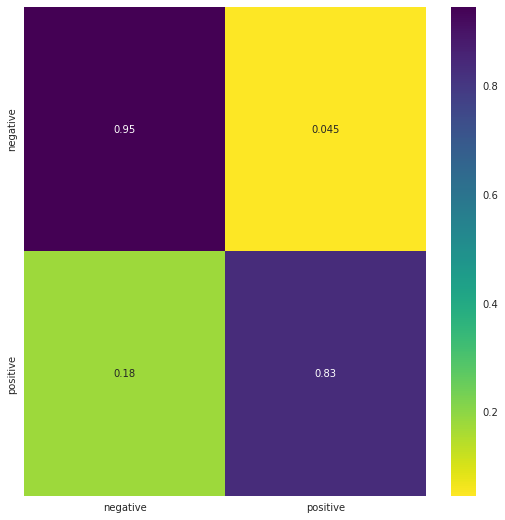

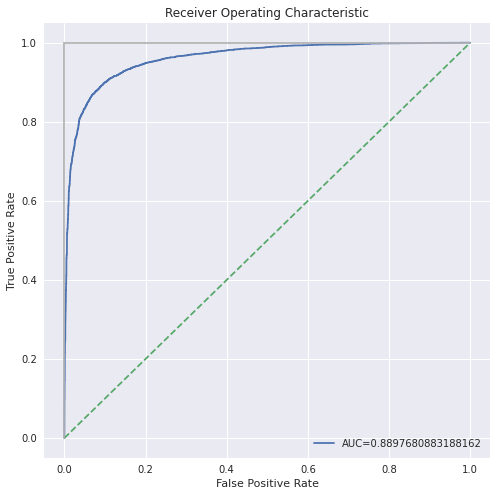

In [13]:
LR = 0.0045
EPOCHS = 5
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
HIDDEN = 48
LAYERS = 2
DROPOUT = 0.15
CLIP_VALUE = 0.7
HEADS = 3
CLASSES = 2
PATIENCE = 2

seedTorch()
model = GRU_06(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
model, bestEp = earlyStop(DEVICE, model, False, EPOCHS, train_dataloader, val_dataloader, LR, optimizer, lossfunc, PATIENCE, CLIP_VALUE)
print("Best F1 score after ", bestEp, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

The performance wasn't that bad so I'll generalise this by using the ModuleList again in a similar manner to attention before.

In [33]:
class GRU_07(torch.nn.Module):
    def __init__(self, input, embedding, hidden, layers, output, heads, dropout=0.1):
        super().__init__()
        self.hidden = hidden
        self.embedding = torch.nn.Embedding(input, embedding)
        self.skip_connections = torch.nn.ModuleList([torch.nn.GRU(input_size=embedding, hidden_size=hidden, num_layers=(layer+1), bidirectional=True) for layer in range(layers)])
        self.dropout = torch.nn.Dropout(p=dropout)
        self.multiheaded_attention = torch.nn.ModuleList([torch.nn.Linear(hidden*2, 1) for _ in range(heads)])
        self.linear = torch.nn.Linear(hidden*2*heads, output)

    def forward(self, X, X_length):
        
        embedded = self.embedding(X)        
        sequence = torch.nn.utils.rnn.pack_padded_sequence(embedded, X_length.cpu())
        output = torch.zeros([embedded.shape[1], self.hidden*2], dtype=torch.float).to(DEVICE)
        for gru_cell in self.skip_connections:
            _, h_0 = gru_cell(sequence)
            h_0 = torch.cat((h_0[-2,:,:], h_0[-1,:,:]), dim=1)
            h_0 = self.dropout(h_0)
            output += h_0
        
        attention_outputs = []
        for attention_head in self.multiheaded_attention:
            attention = F.softmax(attention_head(output), dim=1)
            attention_output = output * attention
            attention_outputs.append(attention_output)
        post_attention = torch.cat(attention_outputs, dim=1)
        
        return self.linear(post_attention)

Then training the network with two layers.

Early stopping on epoch:  4
Best F1 score after  4  epochs.
Training Time: 4.33 minutes

Evaluation Results
_________________________________
Predicted 8075 / 9002 correctly
Mean Loss: 0.50 
Recall: 88.43%
Precision: 90.93%
Accuracy: 89.70%
Macro Averaged F1-score: 89.70%
_________________________________


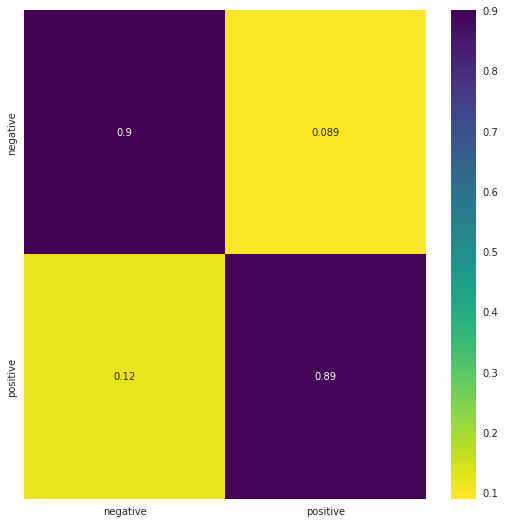

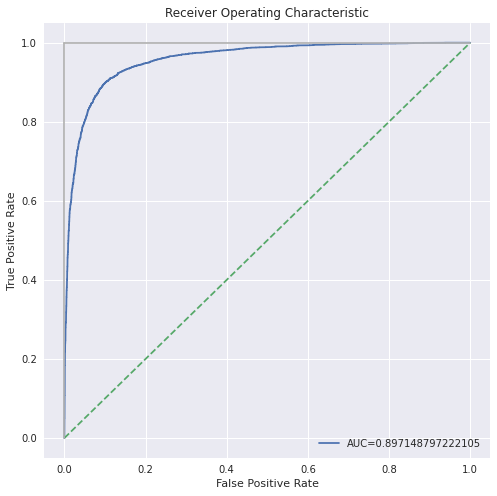

In [151]:
LR = 0.0045
EPOCHS = 6
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
HIDDEN = 39
DROPOUT = 0.15
CLIP_VALUE = 0.6
HEADS = 3
CLASSES = 2
PATIENCE = 2
LAYERS = 2

seedTorch()
model = GRU_07(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
model, bestEp = earlyStop(DEVICE, model, False, EPOCHS, train_dataloader, val_dataloader, LR, optimizer, lossfunc, PATIENCE, CLIP_VALUE)
print("Best F1 score after ", bestEp, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

The network seems to perform better this time. Then trying with three layers.

Early stopping on epoch:  4
Best F1 score after  4  epochs.
Training Time: 8.42 minutes

Evaluation Results
_________________________________
Predicted 7946 / 9002 correctly
Mean Loss: 0.54 
Recall: 94.65%
Precision: 84.11%
Accuracy: 88.27%
Macro Averaged F1-score: 88.21%
_________________________________


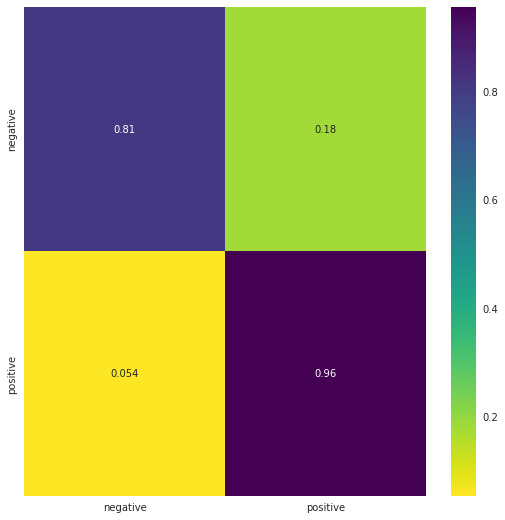

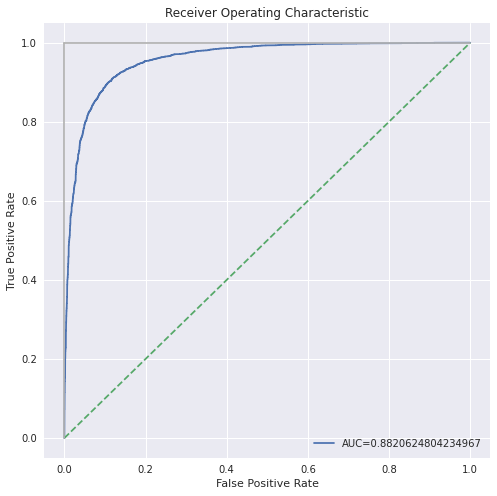

In [152]:
LR = 0.0045
EPOCHS = 6
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
HIDDEN = 39
DROPOUT = 0.15
CLIP_VALUE = 0.6
HEADS = 3
CLASSES = 2
PATIENCE = 2
LAYERS = 3

seedTorch()
model = GRU_07(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
model, bestEp = earlyStop(DEVICE, model, False, EPOCHS, train_dataloader, val_dataloader, LR, optimizer, lossfunc, PATIENCE, CLIP_VALUE)
print("Best F1 score after ", bestEp, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

Slightly worse as expected from previous experiments with three layers.

#### LSTM with skip connections

Then I tried with the LSTM version.

In [28]:
class LSTM_04(torch.nn.Module):
    def __init__(self, input, embedding, hidden, layers, output, heads, dropout=0.1):
        super().__init__()
        self.hidden = hidden
        self.embedding = torch.nn.Embedding(input, embedding)
        self.skip_connections = torch.nn.ModuleList([torch.nn.LSTM(input_size=embedding, hidden_size=hidden, num_layers=(layer+1), bidirectional=True) for layer in range(layers)])
        self.dropout = torch.nn.Dropout(p=dropout)
        self.multiheaded_attention = torch.nn.ModuleList([torch.nn.Linear(hidden*2, 1) for _ in range(heads)])
        self.linear = torch.nn.Linear(hidden*2*heads, output)

    def forward(self, X, X_length):
        
        embedded = self.embedding(X)
        sequence = torch.nn.utils.rnn.pack_padded_sequence(embedded, X_length.cpu())
        
        output = torch.zeros([embedded.shape[1], self.hidden*2], dtype=torch.float).to(DEVICE)
        for lstm_cell in self.skip_connections:
            _, (h_0, _) = lstm_cell(sequence)
            h_0 = torch.cat((h_0[-2,:,:], h_0[-1,:,:]), dim=1)
            h_0 = self.dropout(h_0)
            output += h_0
        
        attention_outputs = []
        for attention_head in self.multiheaded_attention:
            attention = F.softmax(attention_head(output), dim=1)
            attention_output = output * attention
            attention_outputs.append(attention_output)
        
        # Concatenate the attention along the hidden size dimension
        post_attention = torch.cat(attention_outputs, dim=1)
    
        return self.linear(post_attention)

Training for six epochs with three heads and two layers.

Early stopping on epoch:  5
Best F1 score after  5  epochs.
Training Time: 5.52 minutes

Evaluation Results
_________________________________
Predicted 8072 / 9002 correctly
Mean Loss: 0.47 
Recall: 87.79%
Precision: 91.41%
Accuracy: 89.67%
Macro Averaged F1-score: 89.67%
_________________________________


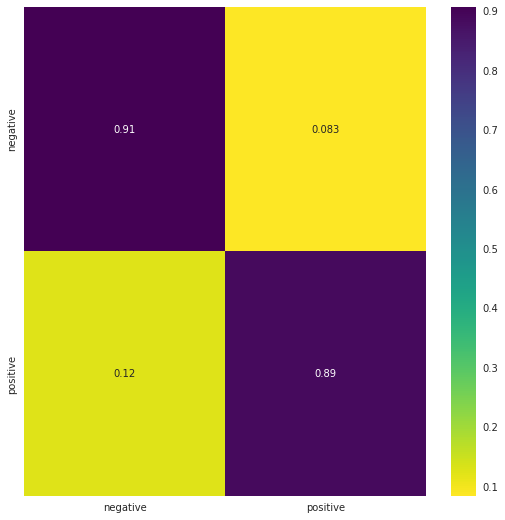

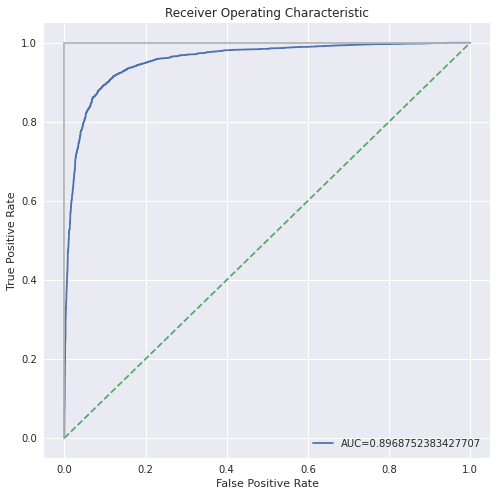

In [161]:
LR = 0.0045
EPOCHS = 6
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
HIDDEN = 39
DROPOUT = 0.15
CLIP_VALUE = 0.6
HEADS = 3
CLASSES = 2
PATIENCE = 2
LAYERS = 2

seedTorch()
model = LSTM_04(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
model, bestEp = earlyStop(DEVICE, model, False, EPOCHS, train_dataloader, val_dataloader, LR, optimizer, lossfunc, PATIENCE, CLIP_VALUE)
print("Best F1 score after ", bestEp, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

### Comparing the Optimal Models with and without Skip Connections

Initially I'll compare the two best models with skip connections below with the models without skip connections.

Epoch 1
__________________________________
loss: 0.704224  [    0/30605]
loss: 0.610583  [ 2048/30605]
loss: 0.552826  [ 4096/30605]
loss: 0.415249  [ 6144/30605]
loss: 0.429978  [ 8192/30605]
loss: 0.442636  [10240/30605]
loss: 0.446071  [12288/30605]
loss: 0.355480  [14336/30605]
loss: 0.357572  [16384/30605]
loss: 0.354120  [18432/30605]
loss: 0.250682  [20480/30605]
loss: 0.151436  [22528/30605]
loss: 0.276183  [24576/30605]
loss: 0.193348  [26624/30605]
loss: 0.060035  [28672/30605]

Evaluation Results
_________________________________
Predicted 4743 / 5401 correctly
Mean Loss: 0.31 
Recall: 94.18%
Precision: 83.53%
Accuracy: 87.82%
Macro Averaged F1-score: 87.77%
_________________________________
Training loss:  0.4109801129324122  validation loss:  0.30627370151806865  and accuracy:  87.81707091279392
__________________________________
Epoch 2
__________________________________
loss: 0.225289  [    0/30605]
loss: 0.176139  [ 2048/30605]
loss: 0.206068  [ 4096/30605]
loss: 0.3753

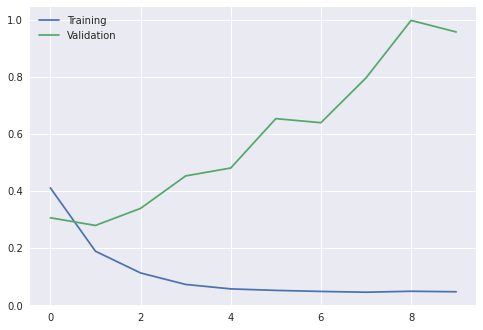

Best F1 score after  5  epochs.
Training Time: 9.29 minutes

Evaluation Results
_________________________________
Predicted 8091 / 9002 correctly
Mean Loss: 0.49 
Recall: 89.72%
Precision: 90.18%
Accuracy: 89.88%
Macro Averaged F1-score: 89.88%
_________________________________


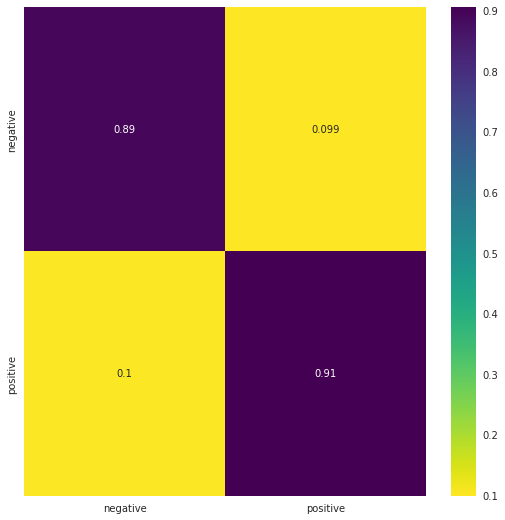

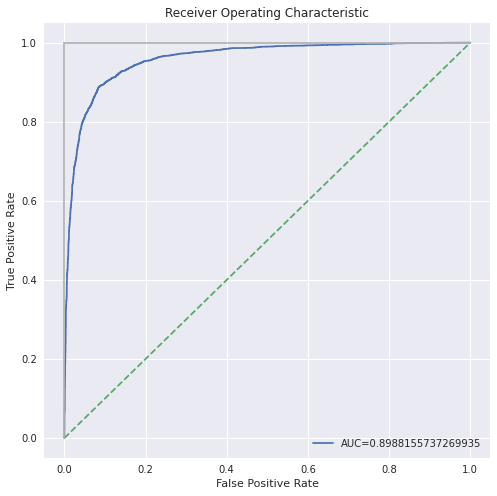

In [170]:
LR = 0.0045
EPOCHS = 10
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
HIDDEN = 48
DROPOUT = 0.15
HEADS = 3
CLASSES = 2
LAYERS = 2

seedTorch()
model = GRU_07(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
best_epoch = optimalModel(DEVICE, model, EPOCHS, train_dataloader, val_dataloader, optimizer, lossfunc, display=True)
print("Best F1 score after ", bestEp, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

seedTorch()
model = GRU_07(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
model.load_state_dict(torch.load('./bestModel.pt'))
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
optimizer.load_state_dict(torch.load('./bestOptimizer.pt'))
model = model.to(DEVICE)

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

Testing with LSTM this time only 6 epochs since it is obvious that it overfits later on and it will finish much sooner.

Epoch 1
__________________________________
loss: 0.700771  [    0/30605]
loss: 0.709428  [ 2048/30605]
loss: 0.597306  [ 4096/30605]
loss: 0.653762  [ 6144/30605]
loss: 0.669880  [ 8192/30605]
loss: 0.605577  [10240/30605]
loss: 0.508454  [12288/30605]
loss: 0.305564  [14336/30605]
loss: 0.518395  [16384/30605]
loss: 0.475952  [18432/30605]
loss: 0.401020  [20480/30605]
loss: 0.276283  [22528/30605]
loss: 0.325709  [24576/30605]
loss: 0.594091  [26624/30605]
loss: 0.472227  [28672/30605]

Evaluation Results
_________________________________
Predicted 4454 / 5401 correctly
Mean Loss: 0.40 
Recall: 83.83%
Precision: 81.57%
Accuracy: 82.47%
Macro Averaged F1-score: 82.46%
_________________________________
Training loss:  0.5184493112293157  validation loss:  0.3987253465243345  and accuracy:  82.46620996111831
__________________________________
Epoch 2
__________________________________
loss: 0.228149  [    0/30605]
loss: 0.302302  [ 2048/30605]
loss: 0.397832  [ 4096/30605]
loss: 0.19497

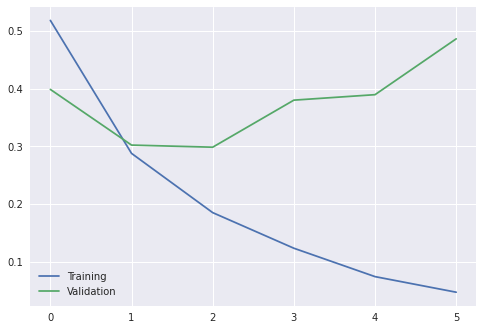

Best F1 score after  5  epochs.
Training Time: 5.81 minutes

Evaluation Results
_________________________________
Predicted 7998 / 9002 correctly
Mean Loss: 0.40 
Recall: 89.39%
Precision: 88.62%
Accuracy: 88.85%
Macro Averaged F1-score: 88.84%
_________________________________


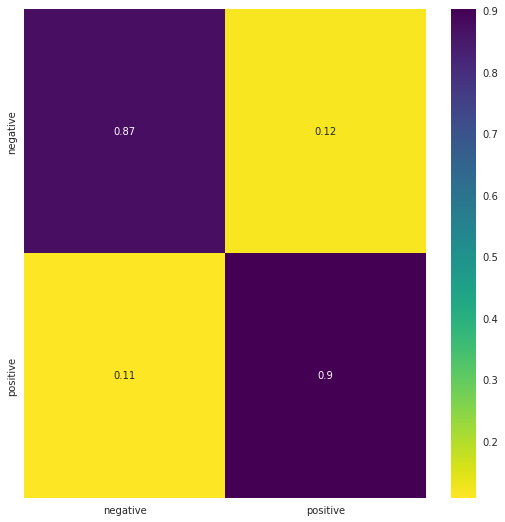

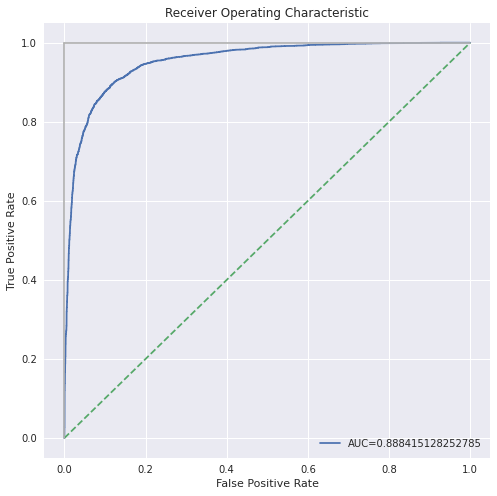

In [173]:
LR = 0.0045
EPOCHS = 6
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
HIDDEN = 48
DROPOUT = 0.15
HEADS = 3
CLASSES = 2
LAYERS = 2

seedTorch()
model = LSTM_04(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
best_epoch = optimalModel(DEVICE, model, EPOCHS, train_dataloader, val_dataloader, optimizer, lossfunc, display=True)
print("Best F1 score after ", bestEp, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

seedTorch()
model = LSTM_04(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
model.load_state_dict(torch.load('./bestModel.pt'))
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
optimizer.load_state_dict(torch.load('./bestOptimizer.pt'))
model = model.to(DEVICE)

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

Comparing without skip connections so defining the best network of the previous notebook with attention.

In [9]:
class LSTM_01(torch.nn.Module):
    def __init__(self, input, embedding, hidden, layers, output, heads, dropout=0.1):
        super().__init__()
        self.embedding = torch.nn.Embedding(input, embedding)
        self.lstm = torch.nn.LSTM(input_size=embedding, hidden_size=hidden, num_layers=layers, bidirectional=True)
        self.dropout = torch.nn.Dropout(p=dropout)
        self.multiheaded_attention = torch.nn.ModuleList([torch.nn.Linear(hidden*2, 1) for _ in range(heads)])
        self.linear = torch.nn.Linear(hidden*2*heads, output)

    def forward(self, X, X_length):
        
        embedded = self.embedding(X)
        sequence = torch.nn.utils.rnn.pack_padded_sequence(embedded, X_length.cpu())
        _, (h_0, _) = self.lstm(sequence)
        h_0 = torch.cat((h_0[-2,:,:], h_0[-1,:,:]), dim=1)
        h_0 = self.dropout(h_0)
        attention_outputs = []
        for attention_head in self.multiheaded_attention:
            attention = F.softmax(attention_head(h_0), dim=1)
            attention_output = h_0 * attention
            attention_outputs.append(attention_output)
        
        h_0 = torch.cat(attention_outputs, dim=1)
        
        output = self.linear(h_0)
        return output

Training the model with the same parameters.

Epoch 1
__________________________________
loss: 0.696541  [    0/30605]
loss: 0.645109  [ 2048/30605]
loss: 0.576133  [ 4096/30605]
loss: 0.821446  [ 6144/30605]
loss: 0.575964  [ 8192/30605]
loss: 0.373983  [10240/30605]
loss: 0.553464  [12288/30605]
loss: 0.269769  [14336/30605]
loss: 0.240752  [16384/30605]
loss: 0.472764  [18432/30605]
loss: 0.390469  [20480/30605]
loss: 0.608675  [22528/30605]
loss: 0.292651  [24576/30605]
loss: 0.178095  [26624/30605]
loss: 0.441705  [28672/30605]

Evaluation Results
_________________________________
Predicted 4781 / 5401 correctly
Mean Loss: 0.29 
Recall: 86.65%
Precision: 89.99%
Accuracy: 88.52%
Macro Averaged F1-score: 88.52%
_________________________________
Training loss:  0.45536284665251103  validation loss:  0.288619714904819  and accuracy:  88.52064432512498
__________________________________
Epoch 2
__________________________________
loss: 0.149684  [    0/30605]
loss: 0.148661  [ 2048/30605]
loss: 0.190805  [ 4096/30605]
loss: 0.09534

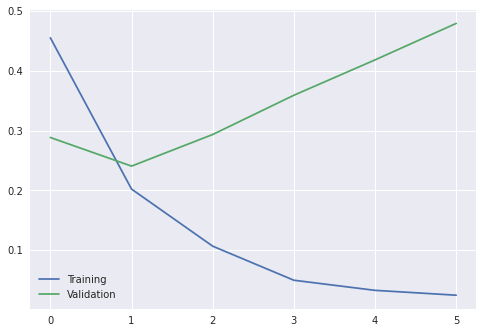

Best F1 score after  5  epochs.
Training Time: 4.09 minutes

Evaluation Results
_________________________________
Predicted 8123 / 9002 correctly
Mean Loss: 0.24 
Recall: 88.80%
Precision: 91.60%
Accuracy: 90.24%
Macro Averaged F1-score: 90.24%
_________________________________


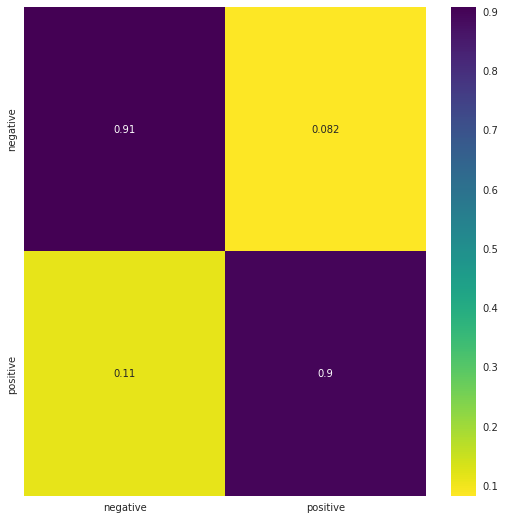

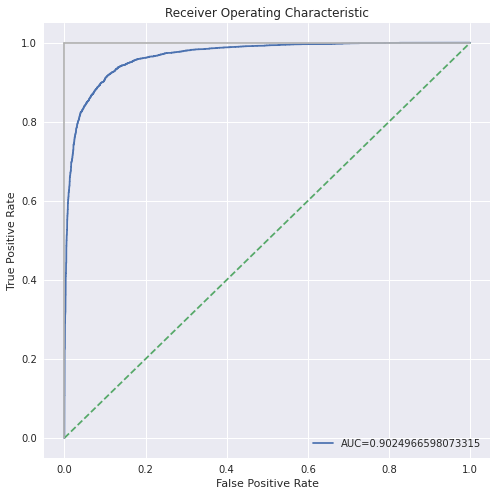

In [175]:
LR = 0.0045
EPOCHS = 6
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
HIDDEN = 48
DROPOUT = 0.15
HEADS = 3
CLASSES = 2
LAYERS = 2

seedTorch()
model = LSTM_01(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
best_epoch = optimalModel(DEVICE, model, EPOCHS, train_dataloader, val_dataloader, optimizer, lossfunc, display=True)
print("Best F1 score after ", bestEp, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

seedTorch()
model = LSTM_01(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
model.load_state_dict(torch.load('./bestModel.pt'))
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
optimizer.load_state_dict(torch.load('./bestOptimizer.pt'))
model = model.to(DEVICE)

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

It's clear by now that the skip connections add nothing to the model and also increase the time so I won't be using it in the later fine tuning models.

## Further Tuning

Since Optuna crashes because it uses more than the allowed RAM in Kaggle I did some experiments locally with Optuna and then used the values in the range that were found below for testing on Kaggle's GPU as well.

In [18]:
EPOCHS = 1
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
LAYERS = 2
CLASSES = 2
DROPOUT = 0.15
HEADS = 3
CLASSES = 2
LAYERS = 2

learning_rates = [0.004, 0.0045, 0.005, 0.0055]
hidden_sizes = [ 39, 48, 54, 64]
clip_values = [ 0.3, 0.6, 0.9]

i=0
bestf1=0
bestac=0
bestpr=0
bestml=0
bestre=0
cv=0
hd=0
lr=0
for LR in learning_rates:
    for HIDDEN in hidden_sizes:
        for CLIP_VALUE in clip_values:
            print("Trial ",  i,": LR: ", LR , " Layers: ", LAYERS, " Hidden Size: ", HIDDEN, " Dropout: ", DROPOUT, " Heads:" , HEADS, " Clip: ", CLIP_VALUE)
            seedTorch()
            model = LSTM_01(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
            optimizer = torch.optim.Adam
            lossfunc = nn.CrossEntropyLoss()
            model, _ = earlyStop(DEVICE, model, False, EPOCHS, train_dataloader, val_dataloader, LR, optimizer, lossfunc, PATIENCE, CLIP_VALUE)
            training_time = str(datetime.timedelta((time.time() - start_time)))
            trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
            if(bestf1<f1):
                bestf1 = float("{:.2f}".format(f1))
                bestac= float("{:.2f}".format(acura))
                bestpr=float("{:.2f}".format(precision))
                bestml=float("{:.2f}".format(meanloss))
                bestre=float("{:.2f}".format(recall))
                cv=CLIP_VALUE
                hd=HIDDEN
                lr=LR
            i+=1
    
print("\nBest Trial\n_____________\nLR: ", LR , "\nLayers: ", LAYERS, "\nHidden Size: ", HIDDEN, "\nDropout: ", DROPOUT, "\nHeads:" , HEADS, "\nClip: ", CLIP_VALUE)
print("_____________\n\nF1-Score: ", bestf1, "%")
print("Accuracy: ", bestac, "%")
print("Precision: ", bestpr, "%")
print("Recall: ", bestre, "%")
print("Mean Loss: ", bestml)

Trial  0 : LR:  0.004  Layers:  2  Hidden Size:  39  Dropout:  0.15  Heads: 3  Clip:  0.3

Evaluation Results
_________________________________
Predicted 7860 / 9002 correctly
Mean Loss: 0.30 
Recall: 81.19%
Precision: 92.50%
Accuracy: 87.31%
Macro Averaged F1-score: 87.26%
_________________________________
Trial  1 : LR:  0.004  Layers:  2  Hidden Size:  39  Dropout:  0.15  Heads: 3  Clip:  0.6

Evaluation Results
_________________________________
Predicted 7932 / 9002 correctly
Mean Loss: 0.28 
Recall: 85.35%
Precision: 90.33%
Accuracy: 88.11%
Macro Averaged F1-score: 88.10%
_________________________________
Trial  2 : LR:  0.004  Layers:  2  Hidden Size:  39  Dropout:  0.15  Heads: 3  Clip:  0.9

Evaluation Results
_________________________________
Predicted 7988 / 9002 correctly
Mean Loss: 0.27 
Recall: 93.46%
Precision: 85.37%
Accuracy: 88.74%
Macro Averaged F1-score: 88.71%
_________________________________
Trial  3 : LR:  0.004  Layers:  2  Hidden Size:  48  Dropout:  0.15  Head

Testing finally with these parameters.

Epoch 1
__________________________________
loss: 0.686537  [    0/30605]
loss: 0.731597  [ 2048/30605]
loss: 0.638742  [ 4096/30605]
loss: 0.481998  [ 6144/30605]
loss: 0.631074  [ 8192/30605]
loss: 0.464912  [10240/30605]
loss: 0.307095  [12288/30605]
loss: 0.416372  [14336/30605]
loss: 0.384882  [16384/30605]
loss: 0.343617  [18432/30605]
loss: 0.274404  [20480/30605]
loss: 0.515537  [22528/30605]
loss: 0.170550  [24576/30605]
loss: 0.377065  [26624/30605]
loss: 0.127634  [28672/30605]

Evaluation Results
_________________________________
Predicted 4858 / 5401 correctly
Mean Loss: 0.26 
Recall: 89.07%
Precision: 91.02%
Accuracy: 89.95%
Macro Averaged F1-score: 89.95%
_________________________________
Training loss:  0.44043130356752264  validation loss:  0.2554203430576437  and accuracy:  89.94630623958525
__________________________________
Epoch 2
__________________________________
loss: 0.387827  [    0/30605]
loss: 0.266878  [ 2048/30605]
loss: 0.218743  [ 4096/30605]
loss: 0.2624

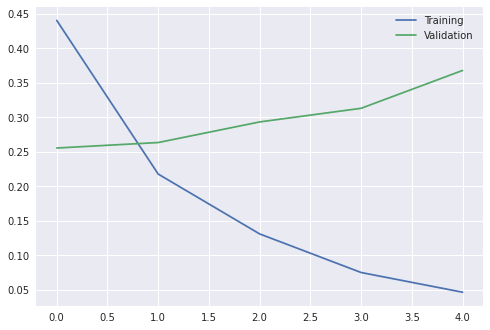

Best F1 score after  0  epochs.
Training Time: 3.36 minutes

Evaluation Results
_________________________________
Predicted 8099 / 9002 correctly
Mean Loss: 0.38 
Recall: 89.08%
Precision: 90.67%
Accuracy: 89.97%
Macro Averaged F1-score: 89.97%
_________________________________


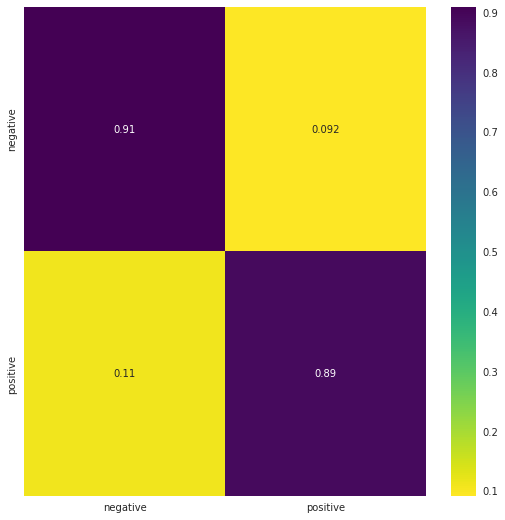

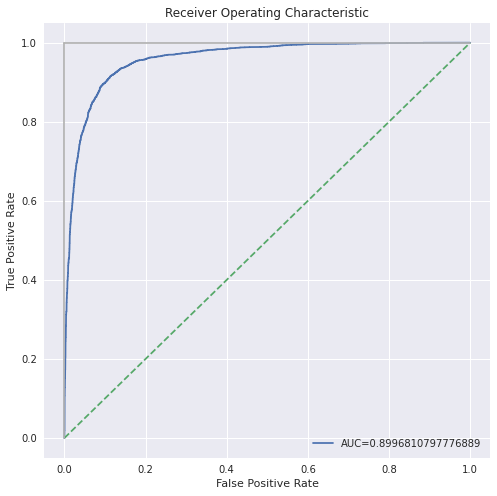

In [19]:
EPOCHS = 5
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
LAYERS = 2
CLASSES = 2
DROPOUT = 0.15
HEADS = 3
CLASSES = 2
LAYERS = 2
LR = 0.0055
HIDDEN = 64
CLIP_VALUE = 0.9

seedTorch()
model = LSTM_01(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
best_epoch = optimalModel(DEVICE, model, EPOCHS, train_dataloader, val_dataloader, optimizer, lossfunc, display=True)
print("Best F1 score after ", bestEp, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

seedTorch()
model = LSTM_01(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
model.load_state_dict(torch.load('./bestModel.pt'))
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
optimizer.load_state_dict(torch.load('./bestOptimizer.pt'))
model = model.to(DEVICE)

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

Epoch 1
__________________________________
loss: 0.707869  [    0/30605]
loss: 0.761516  [ 2048/30605]
loss: 0.648867  [ 4096/30605]
loss: 0.521318  [ 6144/30605]
loss: 0.537073  [ 8192/30605]
loss: 0.639448  [10240/30605]
loss: 0.460852  [12288/30605]
loss: 0.337790  [14336/30605]
loss: 0.306505  [16384/30605]
loss: 0.393759  [18432/30605]
loss: 0.398336  [20480/30605]
loss: 0.481811  [22528/30605]
loss: 0.268854  [24576/30605]
loss: 0.311286  [26624/30605]
loss: 0.201281  [28672/30605]

Evaluation Results
_________________________________
Predicted 4766 / 5401 correctly
Mean Loss: 0.31 
Recall: 87.33%
Precision: 89.38%
Accuracy: 88.24%
Macro Averaged F1-score: 88.24%
_________________________________
Training loss:  0.4894845819639873  validation loss:  0.3116369982630279  and accuracy:  88.24291797815219
__________________________________
Epoch 2
__________________________________
loss: 0.221745  [    0/30605]
loss: 0.309772  [ 2048/30605]
loss: 0.262784  [ 4096/30605]
loss: 0.24844

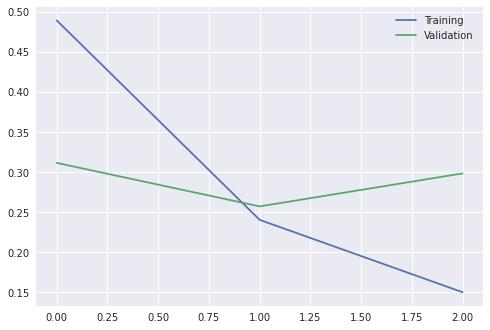

Best F1 score after  0  epochs.
Training Time: 2.85 minutes

Evaluation Results
_________________________________
Predicted 8083 / 9002 correctly
Mean Loss: 0.26 
Recall: 93.08%
Precision: 87.32%
Accuracy: 89.79%
Macro Averaged F1-score: 89.78%
_________________________________


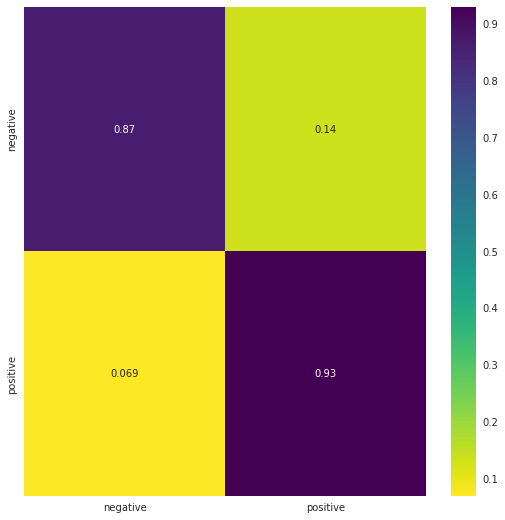

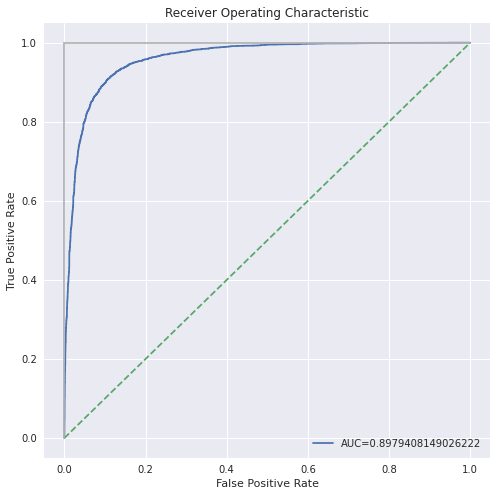

In [29]:
EPOCHS = 3
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
LAYERS = 2
CLASSES = 2
DROPOUT = 0.15
HEADS = 3
CLASSES = 2
LAYERS = 2
LR = 0.0055
HIDDEN = 64
CLIP_VALUE = 0.9

seedTorch()
model = LSTM_04(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
best_epoch = optimalModel(DEVICE, model, EPOCHS, train_dataloader, val_dataloader, optimizer, lossfunc, display=True)
print("Best F1 score after ", bestEp, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

seedTorch()
model = LSTM_04(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
model.load_state_dict(torch.load('./bestModel.pt'))
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
optimizer.load_state_dict(torch.load('./bestOptimizer.pt'))
model = model.to(DEVICE)

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

Epoch 1
__________________________________
loss: 0.675388  [    0/30605]
loss: 0.822657  [ 2048/30605]
loss: 0.793919  [ 4096/30605]
loss: 0.365462  [ 6144/30605]
loss: 0.532884  [ 8192/30605]
loss: 0.247564  [10240/30605]
loss: 0.497765  [12288/30605]
loss: 0.378822  [14336/30605]
loss: 0.196968  [16384/30605]
loss: 0.386654  [18432/30605]
loss: 0.294191  [20480/30605]
loss: 0.232952  [22528/30605]
loss: 0.327018  [24576/30605]
loss: 0.243283  [26624/30605]
loss: 0.844920  [28672/30605]

Evaluation Results
_________________________________
Predicted 4873 / 5401 correctly
Mean Loss: 0.25 
Recall: 89.22%
Precision: 91.41%
Accuracy: 90.22%
Macro Averaged F1-score: 90.22%
_________________________________
Training loss:  0.40603436069911425  validation loss:  0.2541394008863607  and accuracy:  90.22403258655804
__________________________________
Epoch 2
__________________________________
loss: 0.184621  [    0/30605]
loss: 0.123849  [ 2048/30605]
loss: 0.145236  [ 4096/30605]
loss: 0.2596

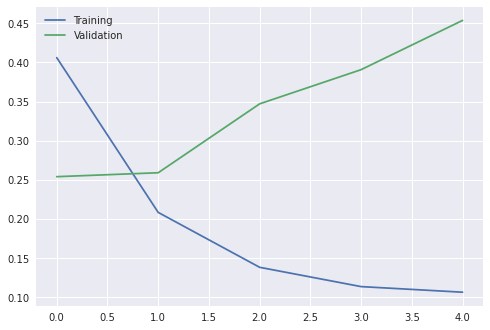

Best F1 score after  0  epochs.
Training Time: 3.25 minutes

Evaluation Results
_________________________________
Predicted 8126 / 9002 correctly
Mean Loss: 0.25 
Recall: 88.57%
Precision: 91.67%
Accuracy: 90.27%
Macro Averaged F1-score: 90.27%
_________________________________


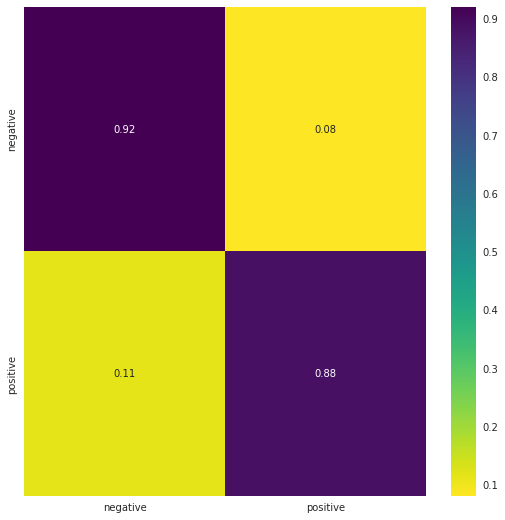

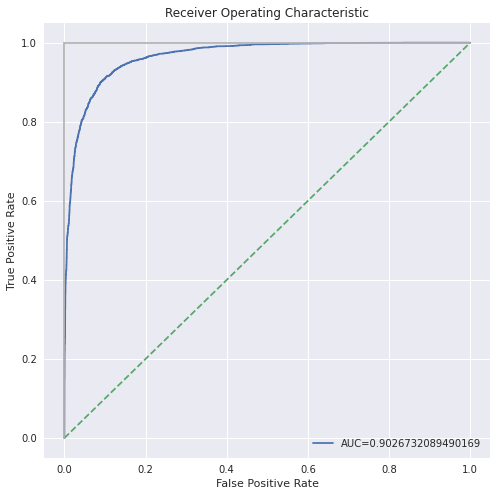

In [31]:
EPOCHS = 5
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
LAYERS = 2
CLASSES = 2
DROPOUT = 0.15
HEADS = 3
CLASSES = 2
LAYERS = 2
LR = 0.0055
HIDDEN = 64
CLIP_VALUE = 0.9

seedTorch()
model = GRU_05(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
best_epoch = optimalModel(DEVICE, model, EPOCHS, train_dataloader, val_dataloader, optimizer, lossfunc, display=True)
print("Best F1 score after ", bestEp, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

seedTorch()
model = GRU_05(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
model.load_state_dict(torch.load('./bestModel.pt'))
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
optimizer.load_state_dict(torch.load('./bestOptimizer.pt'))
model = model.to(DEVICE)

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

And GRU with attention and skip connecyions

Epoch 1
__________________________________
loss: 0.672236  [    0/30605]
loss: 0.767181  [ 2048/30605]
loss: 0.881650  [ 4096/30605]
loss: 0.647183  [ 6144/30605]
loss: 0.421530  [ 8192/30605]
loss: 0.487289  [10240/30605]
loss: 0.487720  [12288/30605]
loss: 0.257455  [14336/30605]
loss: 0.378746  [16384/30605]
loss: 0.202136  [18432/30605]
loss: 0.281882  [20480/30605]
loss: 0.350864  [22528/30605]
loss: 0.233543  [24576/30605]
loss: 0.180915  [26624/30605]
loss: 0.219862  [28672/30605]

Evaluation Results
_________________________________
Predicted 4744 / 5401 correctly
Mean Loss: 0.34 
Recall: 80.98%
Precision: 94.37%
Accuracy: 87.84%
Macro Averaged F1-score: 87.80%
_________________________________
Training loss:  0.44422712959076666  validation loss:  0.3390707936159958  and accuracy:  87.83558600259211
__________________________________
Epoch 2
__________________________________
loss: 0.244043  [    0/30605]
loss: 0.228559  [ 2048/30605]
loss: 0.321035  [ 4096/30605]
loss: 0.3820

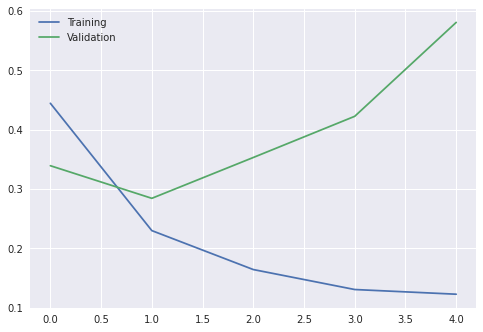

Best F1 score after  0  epochs.
Training Time: 4.56 minutes

Evaluation Results
_________________________________
Predicted 8064 / 9002 correctly
Mean Loss: 0.35 
Recall: 92.86%
Precision: 87.13%
Accuracy: 89.58%
Macro Averaged F1-score: 89.57%
_________________________________


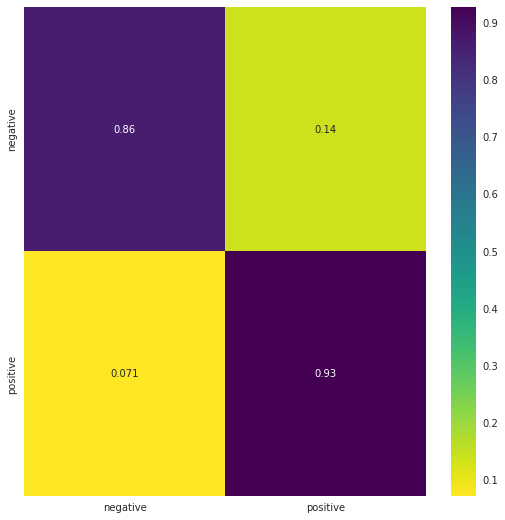

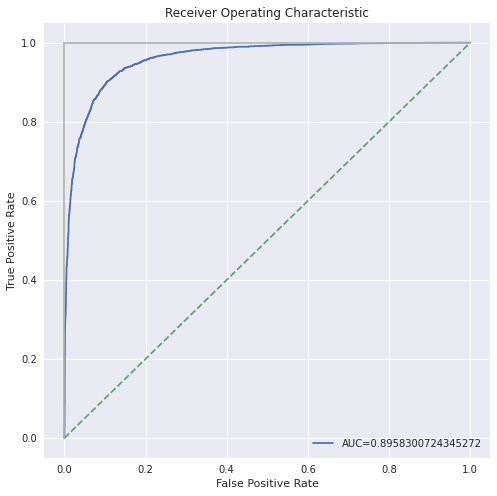

In [34]:
EPOCHS = 5
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
LAYERS = 2
CLASSES = 2
DROPOUT = 0.15
HEADS = 3
CLASSES = 2
LAYERS = 2
LR = 0.0055
HIDDEN = 64
CLIP_VALUE = 0.9

seedTorch()
model = GRU_07(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
best_epoch = optimalModel(DEVICE, model, EPOCHS, train_dataloader, val_dataloader, optimizer, lossfunc, display=True)
print("Best F1 score after ", bestEp, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

seedTorch()
model = GRU_07(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
model.load_state_dict(torch.load('./bestModel.pt'))
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
optimizer.load_state_dict(torch.load('./bestOptimizer.pt'))
model = model.to(DEVICE)

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

Final test with more layers.

Early stopping on epoch:  3
Best F1 score after  3  epochs.
Training Time: 8.95 minutes

Evaluation Results
_________________________________
Predicted 8126 / 9002 correctly
Mean Loss: 0.40 
Recall: 91.02%
Precision: 89.66%
Accuracy: 90.27%
Macro Averaged F1-score: 90.27%
_________________________________


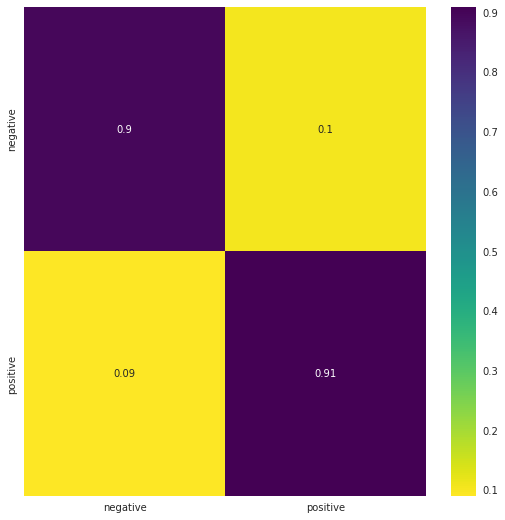

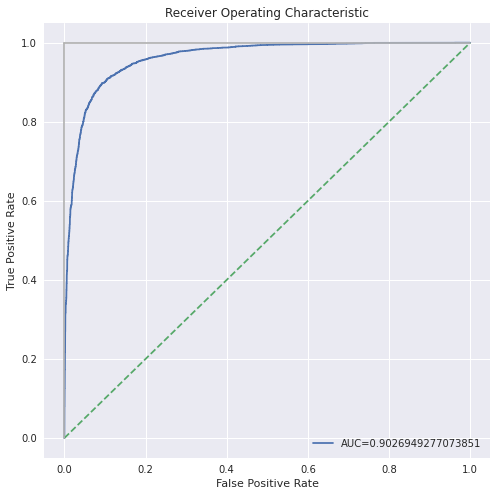

In [36]:
EPOCHS = 5
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
LAYERS = 4
CLASSES = 2
DROPOUT = 0.15
HEADS = 3
CLASSES = 2
LR = 0.005
HIDDEN = 64
CLIP_VALUE = 0.9

seedTorch()
model = GRU_07(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
model, bestEp = earlyStop(DEVICE, model, False, EPOCHS, train_dataloader, val_dataloader, LR, optimizer, lossfunc, PATIENCE, CLIP_VALUE)
print("Best F1 score after ", bestEp, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

Interestingly with more layers the skip connections seem to perform equally good but it takes much longer to train for similar results. Exploring it further with optimal model to see if it overfits or not.

Epoch 1
__________________________________
loss: 0.711808  [    0/30605]
loss: 0.785686  [ 2048/30605]
loss: 0.802904  [ 4096/30605]
loss: 0.702710  [ 6144/30605]
loss: 0.621528  [ 8192/30605]
loss: 0.561659  [10240/30605]
loss: 0.356299  [12288/30605]
loss: 0.271849  [14336/30605]
loss: 0.237522  [16384/30605]
loss: 0.314241  [18432/30605]
loss: 0.363923  [20480/30605]
loss: 0.456470  [22528/30605]
loss: 0.315171  [24576/30605]
loss: 0.196273  [26624/30605]
loss: 0.550768  [28672/30605]

Evaluation Results
_________________________________
Predicted 4811 / 5401 correctly
Mean Loss: 0.27 
Recall: 90.53%
Precision: 88.35%
Accuracy: 89.08%
Macro Averaged F1-score: 89.06%
_________________________________
Training loss:  0.4945672431195791  validation loss:  0.2747213581257318  and accuracy:  89.07609701907055
__________________________________
Epoch 2
__________________________________
loss: 0.116204  [    0/30605]
loss: 0.184497  [ 2048/30605]
loss: 0.398601  [ 4096/30605]
loss: 0.39848

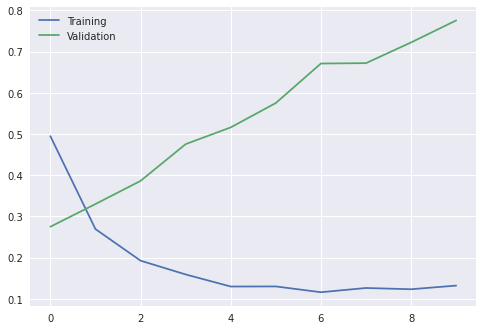

Best F1 score after  3  epochs.
Training Time: 29.70 minutes

Evaluation Results
_________________________________
Predicted 8021 / 9002 correctly
Mean Loss: 0.51 
Recall: 89.39%
Precision: 88.86%
Accuracy: 89.10%
Macro Averaged F1-score: 89.10%
_________________________________


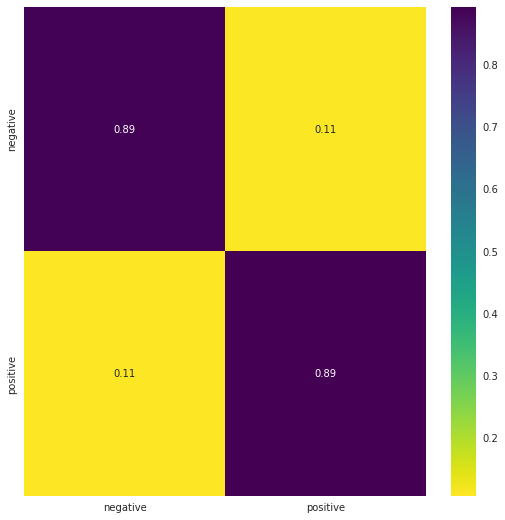

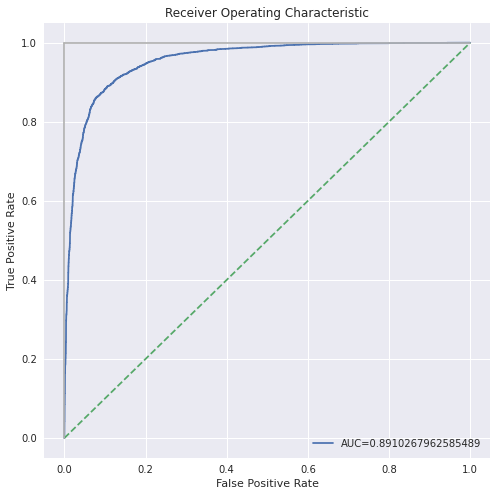

In [37]:
EPOCHS = 10
INPUT = len(REVIEW.vocab)
EMBEDDING = 100
LAYERS = 4
CLASSES = 2
DROPOUT = 0.15
HEADS = 3
CLASSES = 2
LR = 0.005
HIDDEN = 64
CLIP_VALUE = 0.9

seedTorch()
model = GRU_07(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
lossfunc = nn.CrossEntropyLoss()
start_time = time.time()
best_epoch = optimalModel(DEVICE, model, EPOCHS, train_dataloader, val_dataloader, optimizer, lossfunc, display=True)
print("Best F1 score after ", bestEp, " epochs.")
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

seedTorch()
model = GRU_07(INPUT, EMBEDDING, HIDDEN, LAYERS, CLASSES, HEADS, DROPOUT).to(DEVICE)
model.load_state_dict(torch.load('./bestModel.pt'))
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
optimizer.load_state_dict(torch.load('./bestOptimizer.pt'))
model = model.to(DEVICE)

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, DEVICE)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

So again we see the problem is that it overfits and it takes mre time. So the GRU seems to be the best of both worlds so it's the one I'll be using for the testin of the test set.